# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition. 

#### Business Objectives
The objective of this exercise is to create predictive model of of used car prices that can be used to readily asses fair value for used cars. 
#### Resources
To build this model I have utilized dataset of 426k used car sales records from US market.
#### Data Mining Goals
- Build a predicitve model of used car prices for US market.
- Identify weights of parameters.
- Evaluate importance of each parameter on car price.
- Assess what is the simplest model explaiing most of the variance.
#### Project Plan
Work accodring to CRISP-DM Framework:
- Bussiness Understanding
- Data Understanding
- Data Preparation
- Modeling
- Evaluation
- Deployment

## Data Understanding


### Data description:
Total of 426880 entries organized in 18 columns:

    1. id - Unique entry identification number
    2. region - US region
    3. price - sales price in USD
    4. year - cars manufacturing year
    5. manufacturer - cars brand
    6. model - cars model
    7. condition - cars conditon: 'new', 'like new, 'excellent', 'good', 'fair', 'salvage'
    8. cylinders - Number of engines cylinders: '3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders',  'other'
    9. fuel - fueal type : 'gas', 'other', 'diesel', 'hybrid', 'electric'
    10. odometer - readout of odomoeter in miles
    11. title_status - category of the title: 'clean', 'rebuilt', 'salvage', 'lien', 'missing', 'parts only'
    12. transmission - type of transmission: 'automatic', 'other', 'manual'
    13. VIN - Vehicle Identification Number
    14. drive - powered axels: '4wd', 'fwd', 'rwd'
    15. size - Category of car size: 'full-size', 'mid-size', 'compact', 'sub-compact'
    16. type - Category of car type: 'sedan', 'SUV', 'pickup', 'truck', 'other', 'coupe',' hatchback', 'wagon', 'van', 'convertible', 'mini-van', 'offroad', 'bus'
    17. paint_color - car's color: 'white', 'black', 'silver', 'blue', 'red', 'grey', 'green', 'custom', 'brown', 'yellow', 'orange', 'purple'
    18. state - US state.

In [8]:
#Import libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import numpy as np
import plotly.express as px
import pandas as pd
import warnings
import seaborn as sns

In [9]:
# Create pandas Dataframe
df = pd.read_csv('./data/vehicles.csv')

In [10]:
# Display dataframe's key metrics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

ID column was dropped from analysis due to lack of relevancy

In [12]:
# Display key statistics of category 'id'
df['id'].value_counts()

id
7222695916    1
7313139418    1
7313423023    1
7313423324    1
7313424533    1
             ..
7314655506    1
7314655833    1
7314657468    1
7314659947    1
7301591129    1
Name: count, Length: 426880, dtype: int64

Region column was not used due to too many unique positions even though it was adding to predictive power.

In [14]:
# Display key statistics of category 'region'
df['region'].value_counts()

region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64

The distribution of car prices has a very long right tail, with very few entries at high prices. Some entries appear erroneous, reaching over 1 billion. I have removed low end below USD10 and high end  above USD200000

Text(0, 0.5, 'Log10 count')

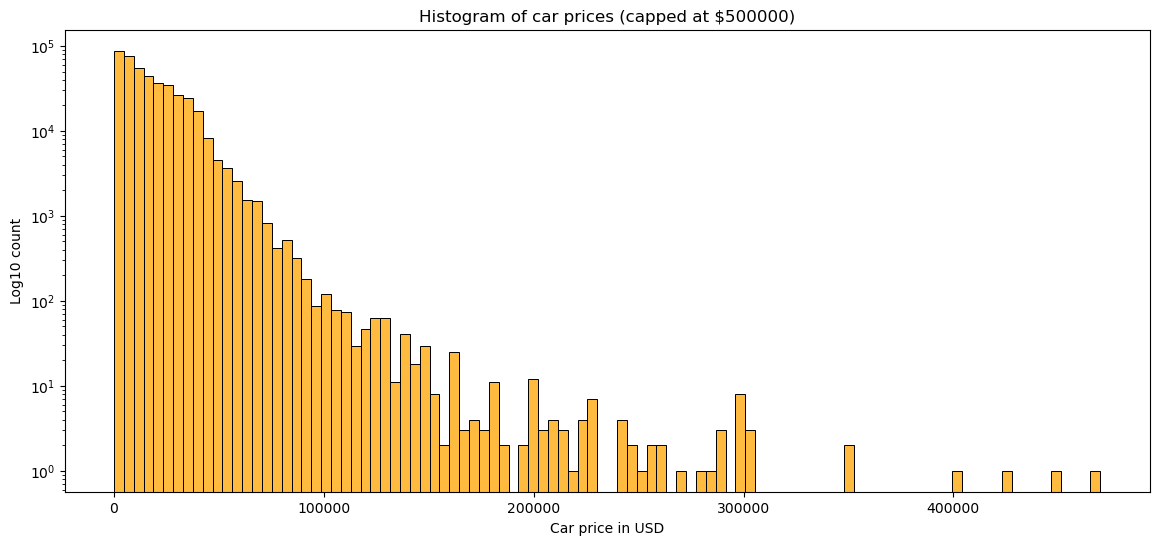

In [16]:
# Display key statistics of category 'price'
plt.figure(figsize=(14, 6))
sns.histplot(df[df['price'] < 500000], x='price', bins=100, color='orange')
plt.yscale('log')
plt.title('Histogram of car prices (capped at $500000)')
plt.xlabel('Car price in USD')
plt.ylabel('Log10 count')

Text(0, 0.5, 'Log10 count')

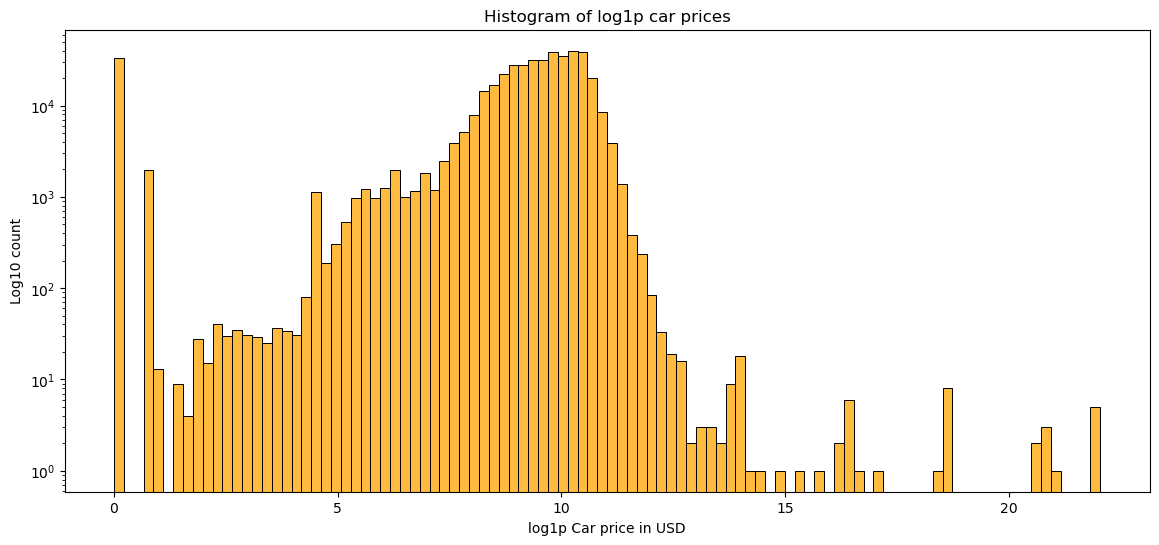

In [17]:
# Display key statistics of category 'price' on log1p scale
plt.figure(figsize=(14, 6))
sns.histplot(df[df['price'] < 500000], x=np.log1p(df['price']), bins=100, color='orange')
plt.yscale('log')
plt.title('Histogram of log1p car prices')
plt.xlabel('log1p Car price in USD')
plt.ylabel('Log10 count')

I have converted year column into age column.

Text(0, 0.5, 'log10 Count')

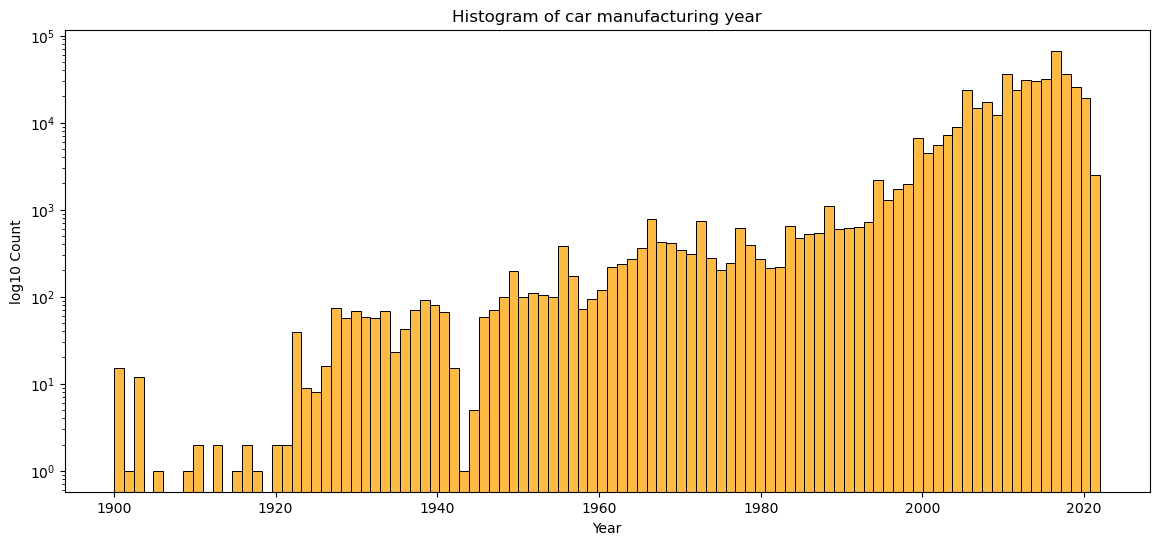

In [19]:
# Display key statistics of category 'year'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='year', bins=100, color='orange')
plt.title('Histogram of car manufacturing year')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('log10 Count')

Manufacturer column was one hot encoded.

In [21]:
# Display key statistics of category 'manufacturer'
df['manufacturer'].value_counts()

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin

Model parameter had almost 30k unique labels and was not used in the analysis.

In [23]:
# Display key statistics of category 'model'
df['model'].value_counts()

model
f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
plymouth fury 1               1
f550 box truck delivery       1
duramax 2500hd                1
3 s sport                     1
Paige Glenbrook Touring       1
Name: count, Length: 29649, dtype: int64

Condition was one hot encoded

In [25]:
# Display key statistics of category 'condition'
df['condition'].value_counts()

condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

Number of cylinders was kept as ordinal value with exception of other that was given one hot encoded parameter

In [27]:
# Display key statistics of category 'cylinders'
df['cylinders'].value_counts()

cylinders
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: count, dtype: int64

Fuel type parameter was One hot encoded

In [29]:
# Display key statistics of category 'fuel'
df['fuel'].value_counts()

fuel
gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: count, dtype: int64

Odometer readings were kept as is.

Text(0, 0.5, 'log10 Count')

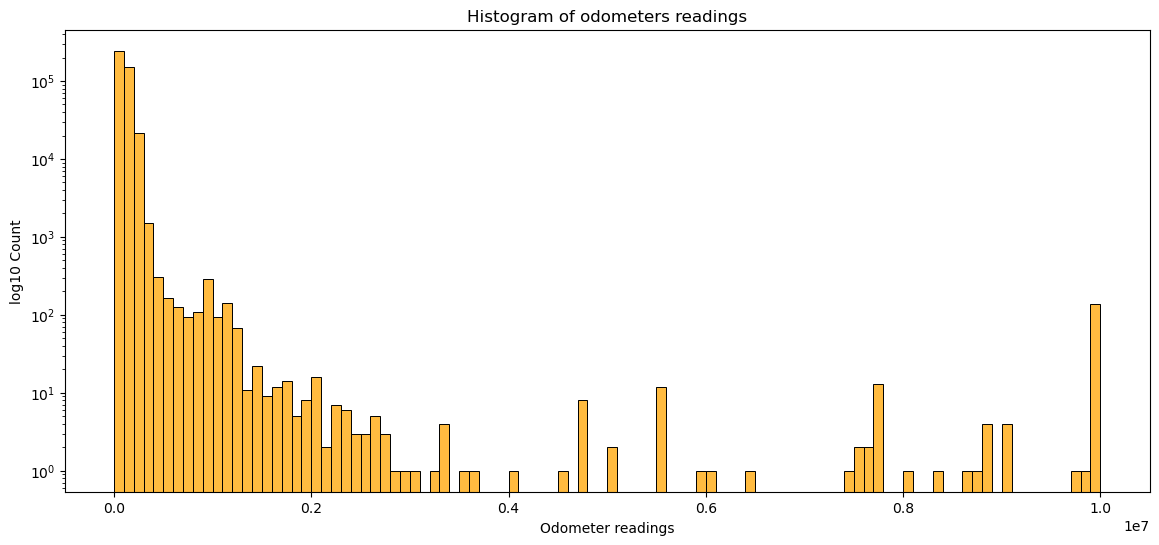

In [30]:
# Display key statistics of category 'odometer'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='odometer', bins=100, color='orange')
plt.title('Histogram of odometers readings')
plt.yscale('log')
plt.xlabel('Odometer readings')
plt.ylabel('log10 Count')

Text(0, 0.5, 'log10 Count')

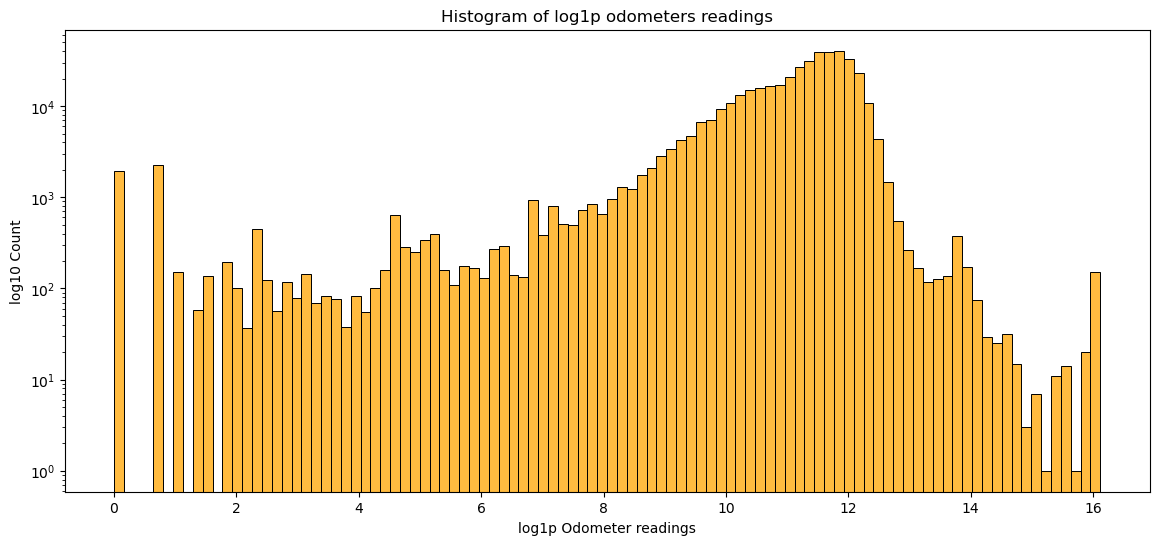

In [31]:
# Display key statistics of category 'odometer'
plt.figure(figsize=(14, 6))
sns.histplot(df, x=np.log1p(df['odometer']), bins=100, color='orange')
plt.title('Histogram of log1p odometers readings')
plt.yscale('log')
plt.xlabel('log1p Odometer readings')
plt.ylabel('log10 Count')

Title status parameter was one hot encoded

In [33]:
#Display key statistics of category 'title_status'
df['title_status'].value_counts()

title_status
clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

Transmission parameter was one hot encoded

In [35]:
#Display key statistics of category 'transmission'
df['transmission'].value_counts()

transmission
automatic    336524
other         62682
manual        25118
Name: count, dtype: int64

VIN parameter was dropped due to lack of relevancy

In [37]:
#Display key statistics of category 'VIN'
df['VIN'].value_counts()

VIN
1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
                    ... 
1GCEK19J78Z219711      1
JA4AT3AW1AZ006543      1
4T1BF28B61U153724      1
JTHCF5C25A5041393      1
SAJGX2749VCOO8376      1
Name: count, Length: 118246, dtype: int64

Drive type parameter was one hot encoded

In [39]:
#Display key statistics of category 'drive'
df['drive'].value_counts()

drive
4wd    131904
fwd    105517
rwd     58892
Name: count, dtype: int64

Size parameter was one hot encoded

In [41]:
#Display key statistics of category 'size'
df['size'].value_counts()

size
full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: count, dtype: int64

Type parameter was one hot encoded

In [43]:
#Display key statistics of category 'type'
df['type'].value_counts()

type
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: count, dtype: int64

Color parmaeter was one how encoded

In [45]:
#Display key statistics of category 'paint_color'
df['paint_color'].value_counts()

paint_color
white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
orange     1984
purple      687
Name: count, dtype: int64

State parameter was not used due to too many unique values even though it was increasing the predictive power of the model.

In [47]:
#Display key statistics of category 'state'
df['state'].value_counts()

state
ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
wi    11398
co    11088
tn    11066
va    10732
il    10387
nj     9742
id     8961
az     8679
ia     8632
ma     8174
mn     7716
ga     7003
ok     6792
sc     6327
mt     6294
ks     6209
in     5704
ct     5188
al     4955
md     4778
nm     4425
mo     4293
ky     4149
ar     4038
ak     3474
la     3196
nv     3194
nh     2981
dc     2970
me     2966
hi     2964
vt     2513
ri     2320
sd     1302
ut     1150
wv     1052
ne     1036
ms     1016
de      949
wy      610
nd      410
Name: count, dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

##### I have removed following columns: id, VIN, region, state manufacturere and model due to irrelevancy or because labels were poorly formatted.

In [50]:
#Drop columns 'id', 'VIN', 'model', 'manufacturer', 'state','region'
df1 = df.drop(columns=['id', 'VIN', 'model', 'manufacturer', 'state','region'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   condition     252776 non-null  object 
 3   cylinders     249202 non-null  object 
 4   fuel          423867 non-null  object 
 5   odometer      422480 non-null  float64
 6   title_status  418638 non-null  object 
 7   transmission  424324 non-null  object 
 8   drive         296313 non-null  object 
 9   size          120519 non-null  object 
 10  type          334022 non-null  object 
 11  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 39.1+ MB


##### In cylinders column, I have converted number of cylinders to integer and created new binary column for other or NaN

In [52]:
# Create a binary column for 'other' and NaN entries from 'cylinders'
df1['cylinders_other'] = df1['cylinders'].apply(lambda x: 1 if x == 'other' or pd.isna(x) else 0)

# Remove 'cylinders' and convert labels to integers, set 'other' and NaN to 0
df1['cylinders'] = df1['cylinders'].apply(lambda x: int(x.split()[0]) if isinstance(x, str) and 'cylinders' in x else 0)

##### In condition column, I have mapped condition to integer and created new binary column for NaN called 

In [54]:
# Create 'condition_nan' column with binary encoding for NaN values
df1['condition_nan'] = df1['condition'].apply(lambda x: 1 if pd.isna(x) else 0)

# Replace labels with integers
condition_mapping = {
    np.NaN : 0,
    'salvage': 1,
    'fair': 2,
    'good': 3,
    'excellent': 4,
    'like new': 5,
    'new': 6
}

df1['condition'] = df1['condition'].map(condition_mapping)

##### Odometer readings were capped to 10,000,000 miles

In [56]:
#Odometer readings were capped to below 10,000,000
df1 = df1[(df1['odometer']<10000000)]

##### Removed cars with prices below USD10 and above USD200,000 as outliers

In [58]:
# Remove car prices below $10 and above $200,000
df1 = df1[(df1['price']>10) & (df1['price']<200000)]

Text(0, 0.5, 'Log10 count')

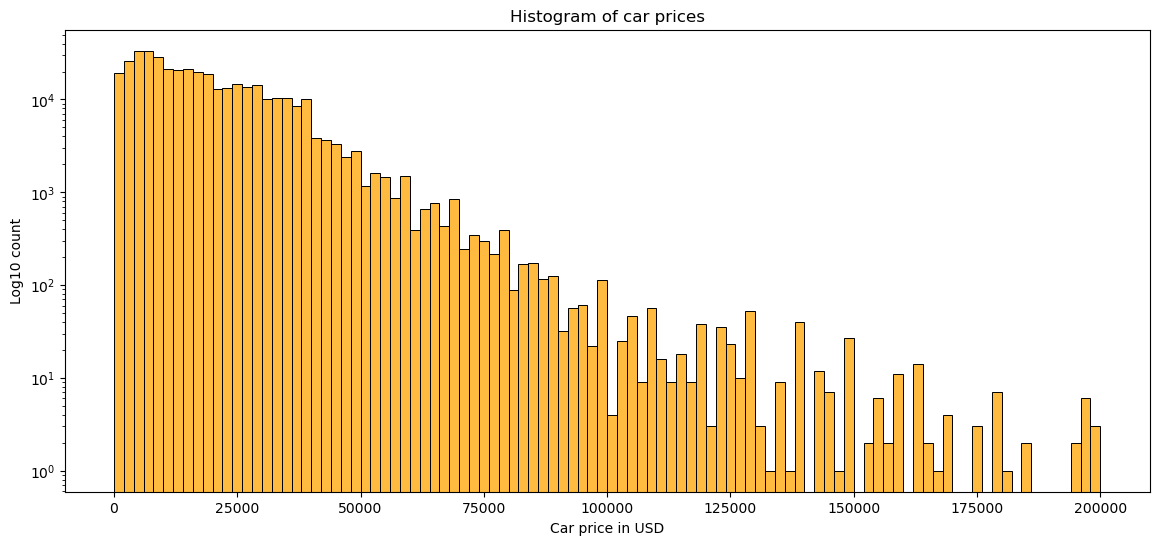

In [59]:
# Display key statistics of category 'car prices'
plt.figure(figsize=(14, 6))
sns.histplot(df1, x=df1['price'], bins=100, color='orange')
plt.yscale('log')
plt.title('Histogram of car prices')
plt.xlabel('Car price in USD')
plt.ylabel('Log10 count')

##### Converted year column into age

In [61]:
#Substract year from the yonges year to convert data into lower value range
df1['year'] = df1['year'].max() - df1['year']

##### I have one hot encoded columns 'manufacturer', 'fuel', 'title_status', 'transmission', 'size', 'type', 'paint_color', 'state', 'drive'. For one hot encoded parameters, missing values received their own column, and missing values in numeric and ordinal columns were dropped, resulting in a final 388360 entries from the original 426880 entries.

In [63]:
#Create column transformer for one hot encodding of columne 'manufacturer', 'fuel', 'title_status','transmission','size','type','paint_color','state','drive' passthrough other collumns
ohe = make_column_transformer(
    (OneHotEncoder(drop = 'if_binary', handle_unknown='ignore', sparse_output=False), ['size','paint_color','drive', 'fuel','transmission','type','title_status']),
    remainder='passthrough'
)
# Fit transform the df1 dataset
ohe_fit = ohe.fit_transform(df1)
# Build df2 dataframe out of transformed data
df2 = pd.DataFrame(data=ohe_fit, columns=ohe.get_feature_names_out()).dropna()

##### Split data 4:1 between training and development datasets

In [65]:
#Drop column 'remainder__price' and assign to X
X = df2.drop(columns='remainder__price')
#Rename column 'remainder__price' to 'price
# create an array y from 'price' column
y = (df2['remainder__price'])
#Split data between train and development set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=22)

##### Create polynomial degree=2 dataset

In [67]:
#Create polynomial features
pohe = make_column_transformer((PolynomialFeatures(include_bias = False, degree = 2), make_column_selector(dtype_include=np.number)),
                               remainder='passthrough')
pohe_fit = pohe.fit_transform(X)
X2 = pd.DataFrame(data=pohe_fit, columns=pohe.get_feature_names_out()).dropna()

#Split data between train and development set
X2_train, X2_test = train_test_split(X2, test_size=0.2, random_state=22)


## Modeling

### Linear Regression of all parameters ('size', 'paint_color', 'drive', 'fuel', transmission', 'type', 'title_status', 'year', 'condition', 'condition_nan', 'cylinders', 'cylinders_other', 'odometer'_nan )

In [70]:
#Call Linear regression 
linreg = LinearRegression(n_jobs=-1).fit(X_train, y_train)

#Predict train and test values
linreg_train_preds = linreg.predict(X_train)
linreg_test_preds = linreg.predict(X_test)

#Calculate MSE for train and test set
linreg_train_mse = mean_squared_error(y_train, linreg_train_preds)
linreg_test_mse = mean_squared_error(y_test, linreg_test_preds)

#Print R2 score, train and Test MSE
print(f'Score: {linreg.score(X_test, y_test)}')
print(f'Train MSE: {round(linreg_train_mse,3)}')
print(f'Test MSE: {round(linreg_test_mse,3)}')

#Perform feature importance permutation
r = permutation_importance(linreg, X_test, y_test,
                           n_repeats=30,
                           random_state=0,
                           n_jobs=-1)

#Get names of parameters
selected_features = linreg.feature_names_in_
selected_features_clean = [name.replace('remainder__', '').replace('onehotencoder__', '') for name in selected_features]

#Create dataframe of coefficients
best_estimator_coef = linreg.coef_
R1 = pd.DataFrame([best_estimator_coef], columns=selected_features_clean, index=['Linear Regression, Hold-out crossvalidation, non-polynomial'])
R1[['Train MSE','Test MSE', 'R2_score']] =linreg_train_mse, linreg_test_mse, linreg.score(X_test, y_test)

#Create Dataframe of feature importance
Importance1 = pd.DataFrame(data=[r.importances_mean, r.importances_std, linreg.coef_],
                          columns=selected_features_clean,
                          index=['Importance','std_dev','Coefficient']).transpose().sort_values(by='Importance',ascending=False)
#Print first 20 elements of the Importance dataframe
Importance1.head(20)

Score: 0.39690541613266106
Train MSE: 134794065.806
Test MSE: 134530070.002


,Importance,std_dev,Coefficient
cylinders,0.298092,0.002289,1803.126085
cylinders_other,0.280153,0.002964,11471.554907
condition_nan,0.247397,0.002056,10988.359709
condition,0.168288,0.001740,2359.637217
year,0.154338,0.001450,-432.108019
fuel_diesel,0.046701,0.000799,9065.718648
odometer,0.031404,0.000766,-0.011182
transmission_other,0.029512,0.000795,4952.378183
fuel_gas,0.020746,0.000669,-4107.123305
drive_fwd,0.019469,0.000623,-3374.701390


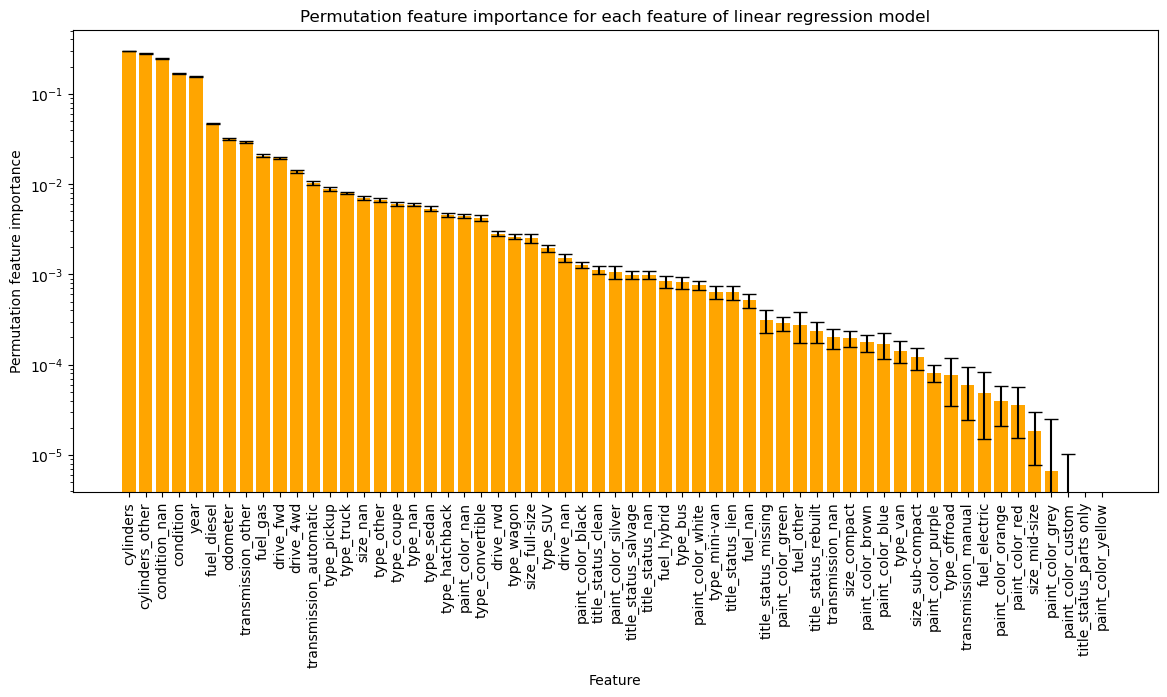

In [71]:
#Plot feature importance
plt.figure(figsize=(14, 6))
plt.bar(Importance1.index, Importance1['Importance'], yerr=Importance1['std_dev'], capsize=5, color='orange')
# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.yscale('log')
plt.ylabel('Permutation feature importance')
plt.title('Permutation feature importance for each feature of linear regression model')
# Save the plot to a file
plt.savefig('./Images/Fig1.png', format='png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

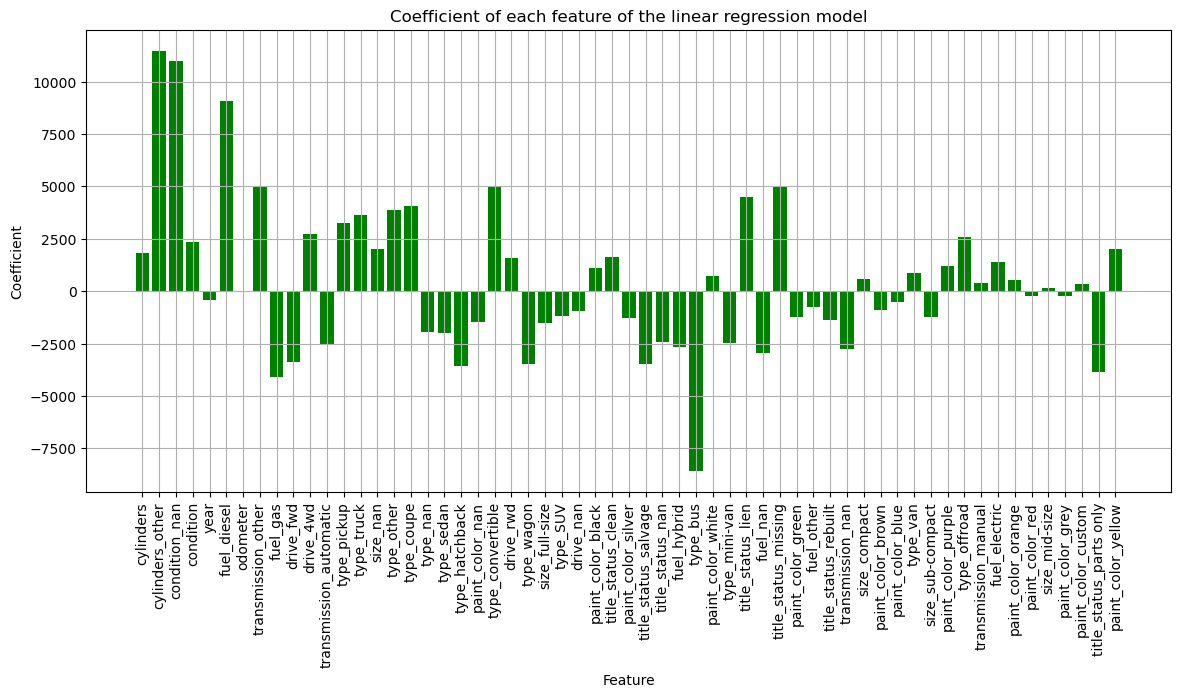

In [72]:
#Plot feature coefficients
plt.figure(figsize=(14, 6))
plt.bar(Importance1.index, Importance1['Coefficient'],capsize=5, color='Green')
# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Coefficient of each feature of the linear regression model')
plt.grid(True)
# Save the plot to a file
plt.savefig('./Images/Fig1b.png', format='png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

### Lasso Regression of all parameters ('size', 'paint_color', 'drive', 'fuel', transmission', 'type', 'title_status', 'year', 'condition', 'condition_nan', 'cylinders', 'cylinders_other', 'odometer'

In [74]:
#Create Lasso pipeline calling for standard scaler and lasso model with alpha parameter dictionary
lasso_param_dict = {'lasso__alpha': np.logspace(-1.5, 1.5, 10)}
lasso_pipe = Pipeline([('scaler',StandardScaler()),('lasso',Lasso())])

#Perform Gridsearch of alpha hyperparameter with 10-fold crossvalidation
lasso_grid = GridSearchCV(estimator=lasso_pipe, param_grid=lasso_param_dict, 
                          cv=10, 
                          n_jobs=-1).fit(X_train,y_train)

#Predict Train and test values
lasso_train_preds = lasso_grid.predict(X_train)
lasso_test_preds = lasso_grid.predict(X_test)

#Caluclate train and test mean square error
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

#Print R2 score, Mean square errors and best alpha hyperparameter
print(f'Score: {lasso_grid.best_estimator_.score(X_test, y_test)}')
print(f'Train MSE: {round(lasso_train_mse,3)}')
print(f'Test MSE: {round(lasso_test_mse,3)}')
print(lasso_grid.best_params_)

#Get names of parameters
selected_features = lasso_grid.feature_names_in_
selected_features_clean = [name.replace('remainder__', '').replace('onehotencoder__', '') for name in selected_features]

#Create dataframe of coefficients
best_estimator_coef = lasso_grid.best_estimator_.named_steps['lasso'].coef_
R2 = pd.DataFrame([best_estimator_coef], columns=selected_features_clean, index=['Lasso Regression, 10-fold cross-validation, non-polynomial'])
R2[['Train MSE','Test MSE','R2_score']] =lasso_train_mse, lasso_test_mse, lasso_grid.best_estimator_.score(X_test, y_test)

#perform feature importance permutation 
r = permutation_importance(lasso_grid.best_estimator_, X_test, y_test,
                           n_repeats=30,
                           random_state=0,
                           n_jobs=-1)


#Create a dataframe of feature importance
Importance2 = pd.DataFrame(data=[r.importances_mean, r.importances_std, lasso_grid.best_estimator_.named_steps['lasso'].coef_],
                          columns=selected_features_clean,
                          index=['Importance','std_dev','Coefficient']).transpose().sort_values(by='Importance',ascending=False)

Importance2.head(20)

C:\Users\grzyb\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+12, tolerance: 6.995e+09
  model = cd_fast.enet_coordinate_descent(


Score: 0.3969055727641184
Train MSE: 134794065.929
Test MSE: 134530035.063
{'lasso__alpha': 0.03162277660168379}


,Importance,std_dev,Coefficient
cylinders,0.298043,0.002288,5724.199372
cylinders_other,0.280105,0.002963,5643.403991
condition_nan,0.247313,0.002056,5341.568396
condition,0.168221,0.001740,4266.599528
year,0.154339,0.001450,-4131.735314
fuel_diesel,0.074056,0.001013,2864.674131
transmission_automatic,0.058120,0.001200,-2538.161972
odometer,0.031404,0.000766,-1858.089574
drive_4wd,0.024854,0.000739,1677.185678
type_pickup,0.011630,0.000474,1140.347510


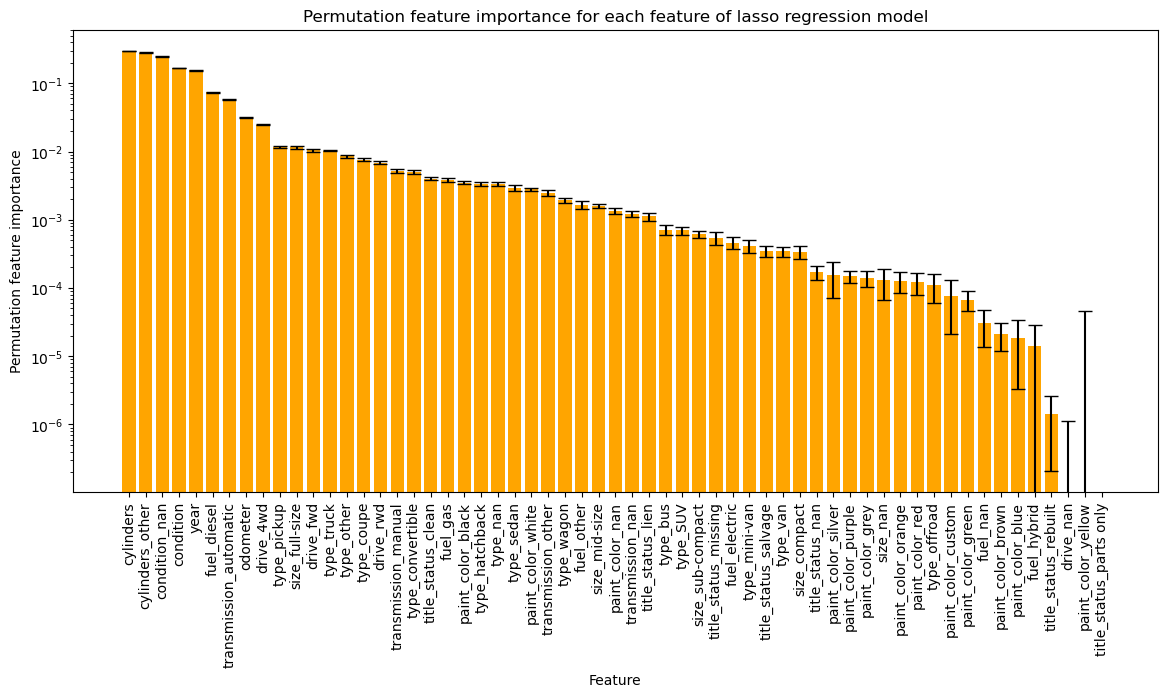

In [75]:
#Plot feature importance
plt.figure(figsize=(14, 6))
plt.bar(Importance2.index, Importance2['Importance'], yerr=Importance2['std_dev'], capsize=5, color='orange')

# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.yscale('log')
plt.ylabel('Permutation feature importance')
plt.title('Permutation feature importance for each feature of lasso regression model')
# Save the plot to a file
plt.savefig('./Images/Fig2.png', format='png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

### Ridge Regression, 10-fold cross-validation, non-polynomial of all parameters ('size', 'paint_color', 'drive', 'fuel', transmission', 'type', 'title_status', 'year', 'condition', 'condition_nan', 'cylinders', 'cylinders_other', 'odometer'_nan )

In [77]:
# Call Ridge model pipeline with Standard scalar
ridge_param_dict = {'ridge__alpha': np.logspace(0, 5, 20)}
ridge_pipe = Pipeline([('scaler',StandardScaler()),('ridge',Ridge())])

#Perform Grid Search of alpha hyperparameters with 10-fold cross validation     
ridge_grid = GridSearchCV(estimator=ridge_pipe, param_grid=ridge_param_dict, 
                          cv=10, 
                          n_jobs=-1).fit(X_train,y_train)

#Predict Test and Train values
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)

# Calculate Mean Squared Errors for Train and Test
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

#Print R2 score, Mean square errors and best alpha hyperparameter
print(f'Score: {ridge_grid.best_estimator_.score(X_test, y_test)}')
print(f'Train MSE: {round(ridge_train_mse,3)}')
print(f'Test MSE: {round(ridge_test_mse,3)}')
print(ridge_grid.best_params_)

#Get names of parameters
selected_features = ridge_grid.feature_names_in_
selected_features_clean = [name.replace('remainder__', '').replace('onehotencoder__', '') for name in selected_features]

#Create dataframe of coefficients
best_estimator_coef = ridge_grid.best_estimator_.named_steps['ridge'].coef_
R3 = pd.DataFrame([best_estimator_coef], columns=selected_features_clean, index=['Ridge Regression, 10-fold cross-validation, non-polynomial'])
R3[['Train MSE','Test MSE', 'R2_score']] =ridge_train_mse, ridge_test_mse, ridge_grid.best_estimator_.score(X_test, y_test)

#perform feature importance permutation 
r = permutation_importance(ridge_grid.best_estimator_, X_test, y_test,
                           n_repeats=30,
                           random_state=0,
                           n_jobs=-1)

#Create a dataframe of feature importance
Importance3 = pd.DataFrame(data=[r.importances_mean, r.importances_std, ridge_grid.best_estimator_.named_steps['ridge'].coef_],
                          columns=selected_features_clean,
                          index=['Importance','std_dev','Coefficient']).transpose().sort_values(by='Importance',ascending=False)

Importance3.head(20)

Score: 0.39690547065139326
Train MSE: 134794065.895
Test MSE: 134530057.84
{'ridge__alpha': 1.8329807108324359}


,Importance,std_dev,Coefficient
cylinders,0.298025,0.002288,5724.025557
cylinders_other,0.280089,0.002963,5643.247149
condition_nan,0.247325,0.002056,5341.698813
condition,0.168230,0.001740,4266.722552
year,0.154337,0.001450,-4131.714371
fuel_diesel,0.049669,0.000824,2341.861953
odometer,0.031404,0.000766,-1858.098987
transmission_other,0.022786,0.000693,1580.416203
drive_fwd,0.018585,0.000608,-1424.430033
fuel_gas,0.017984,0.000622,-1407.124372


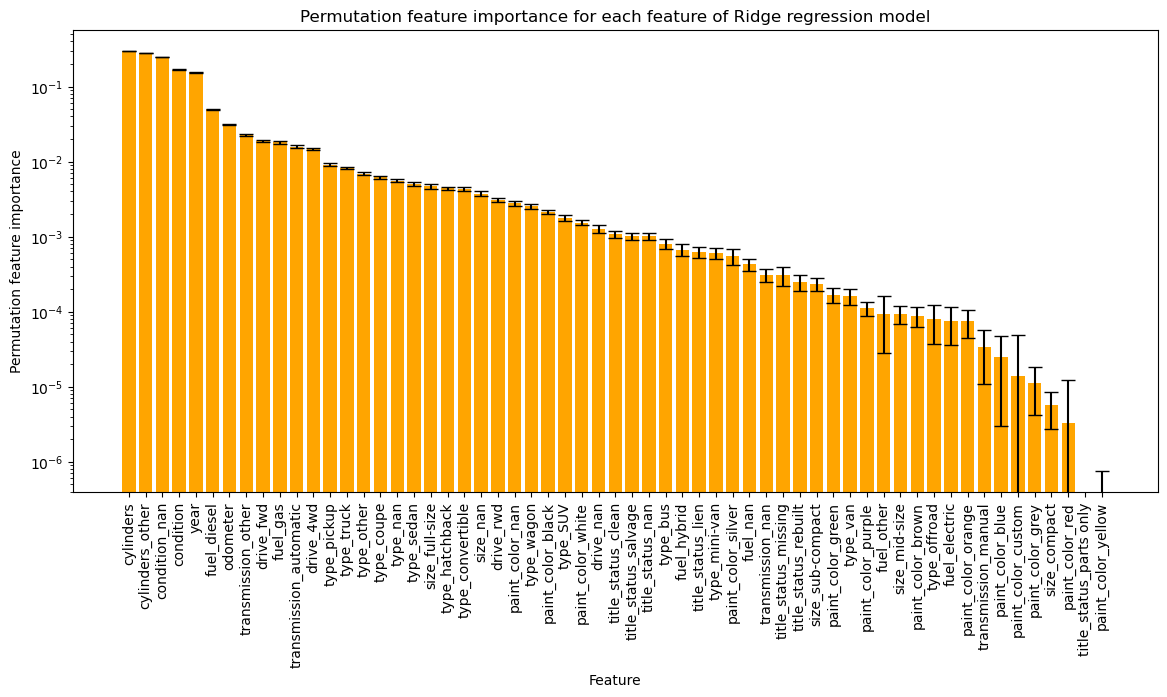

In [78]:
#Create a plot of feature importance
plt.figure(figsize=(14, 6))
plt.bar(Importance3.index, Importance3['Importance'], yerr=Importance3['std_dev'], capsize=5, color='orange')

# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.yscale('log')
plt.ylabel('Permutation feature importance')
plt.title('Permutation feature importance for each feature of Ridge regression model')
# Save the plot to a file
plt.savefig('./Images/Fig3.png', format='png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

### Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg), n=16

In [80]:
#Create selector pipeline with Sequential Feature Selection and Linear Regression esitmator for 16 features.
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression(),n_features_to_select=16)),
                          ('linreg', LinearRegression(n_jobs=-1))]).fit(X_train, y_train)

#Predict Test and Train values
train_preds = selector_pipe.predict(X_train)
test_preds = selector_pipe.predict(X_test)

# Calculate Mean Squared Errors for Train and Test
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

#Print R2 score, Mean square errors and best alpha hyperparameter
print(f'Score: {selector_pipe.score(X_test, y_test)}')
print(f'Train MSE: {round(selector_train_mse,3)}')
print(f'Test MSE: {round(selector_test_mse,3)}')

#Get names of parameters
selected_features = selector_pipe.named_steps['selector'].get_feature_names_out()
selected_features_clean = [name.replace('remainder__', '').replace('onehotencoder__', '') for name in selected_features]
#Get coefficientst
best_estimator_coef = selector_pipe.named_steps['linreg'].coef_
#Create dataframe of coefficients
R4 = pd.DataFrame([best_estimator_coef], columns=selected_features_clean, index=['Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg n=16)'])
R4[['Train MSE','Test MSE', 'R2_score']] =selector_train_mse, selector_test_mse, selector_pipe.score(X_test, y_test)

#Perform feature importance permutation 
r = permutation_importance(selector_pipe.named_steps['linreg'], X_test[selected_features], y_test,
                           n_repeats=30,
                           random_state=0,
                           n_jobs=-1)

#Create a dataframe of feature importance
Importance4 = pd.DataFrame(data=[r.importances_mean, r.importances_std, best_estimator_coef],
                          columns=selected_features_clean,
                          index=['Importance','std_dev','Coefficient']).transpose().sort_values(by='Importance',ascending=False)
Importance4.head(20)

Score: 0.3732525265020361
Train MSE: 140430776.646
Test MSE: 139806232.287


C:\Users\grzyb\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Importance,std_dev,Coefficient
condition_nan,0.222542,0.001985,10420.409050
condition,0.141801,0.001582,2165.210819
year,0.132669,0.001440,-400.873575
drive_fwd,0.100236,0.001468,-7719.116068
transmission_other,0.079620,0.001399,8147.182535
fuel_diesel,0.058327,0.000923,10145.348519
type_pickup,0.034570,0.000814,6411.436558
drive_nan,0.032610,0.000685,-4160.974767
odometer,0.031512,0.000799,-0.011195
type_truck,0.030562,0.000574,6985.395512


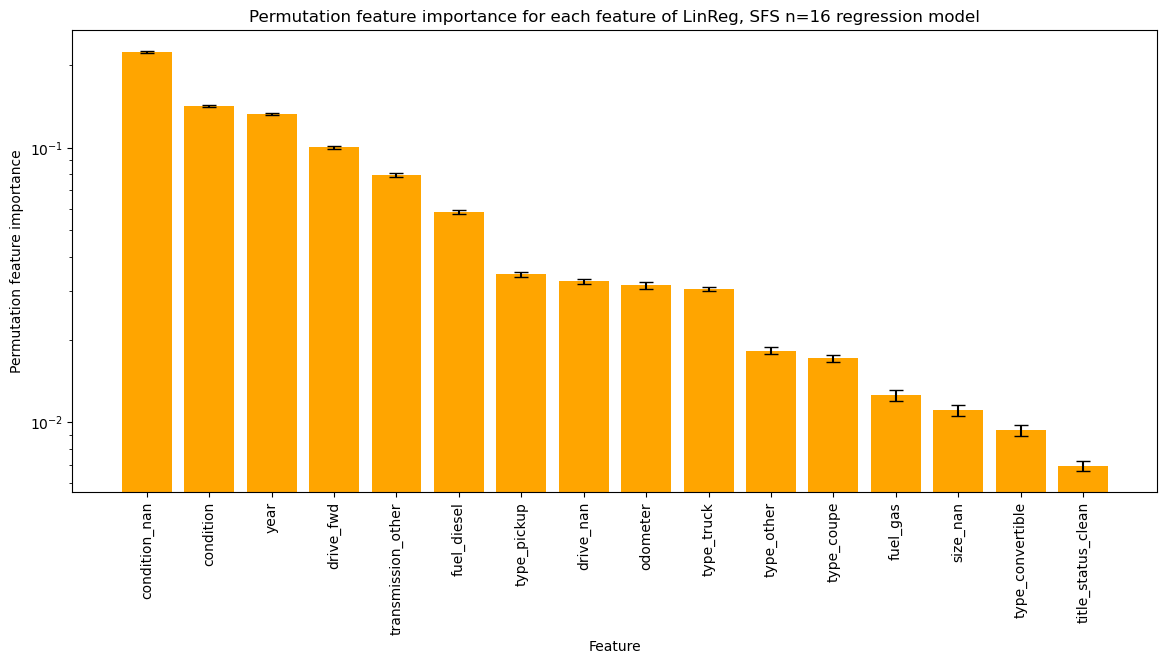

In [81]:
#Create a plot of feature importance
plt.figure(figsize=(14, 6))
plt.bar(Importance4.index, Importance4['Importance'], yerr=Importance4['std_dev'], capsize=5, color='orange')

# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.yscale('log')
plt.ylabel('Permutation feature importance')
plt.title('Permutation feature importance for each feature of LinReg, SFS n=16 regression model')
# Save the plot to a file
plt.savefig('./Images/Fig4.png', format='png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

### Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg), n=6

In [83]:
#Create selector pipeline with Sequential Feature Selection and Linear Regression esitmator for 6 features.
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression(),n_features_to_select=6)),
                          ('linreg', LinearRegression(n_jobs=-1))]).fit(X_train, y_train)

#Predict Test and Train values
train_preds = selector_pipe.predict(X_train)
test_preds = selector_pipe.predict(X_test)

# Calculate Mean Squared Errors for Train and Test
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

#Print R2 score, Mean square errors and best alpha hyperparameter
print(f'Score: {selector_pipe.score(X_test, y_test)}')
print(f'Train MSE: {round(selector_train_mse,3)}')
print(f'Test MSE: {round(selector_test_mse,3)}')

#Get names of parameters
selected_features = selector_pipe.named_steps['selector'].get_feature_names_out()
selected_features_clean = [name.replace('remainder__', '').replace('onehotencoder__', '') for name in selected_features]
#Get coefficientst
best_estimator_coef = selector_pipe.named_steps['linreg'].coef_
#Create dataframe of coefficients
R5 = pd.DataFrame([best_estimator_coef], columns=selected_features_clean, index=['Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg n=6)'])
R5[['Train MSE','Test MSE', 'R2_score']] =selector_train_mse, selector_test_mse, selector_pipe.score(X_test, y_test)

#Perform feature importance permutation 
r = permutation_importance(selector_pipe.named_steps['linreg'], X_test[selected_features], y_test,
                           n_repeats=30,
                           random_state=0,
                           n_jobs=-1)

#Create a dataframe of feature importance
Importance5 = pd.DataFrame(data=[r.importances_mean, r.importances_std, best_estimator_coef],
                          columns=selected_features_clean,
                          index=['Importance','std_dev','Coefficient']).transpose().sort_values(by='Importance',ascending=False)
Importance5.head(20)

Score: 0.298699114733772
Train MSE: 157368383.915
Test MSE: 156436585.091


C:\Users\grzyb\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Importance,std_dev,Coefficient
drive_fwd,0.195519,0.001861,-10799.397848
year,0.152729,0.001663,-429.091549
fuel_gas,0.095261,0.001610,-8867.933517
drive_nan,0.050218,0.000853,-5177.698724
transmission_other,0.048638,0.001208,6341.290380
odometer,0.035186,0.000840,-0.011794


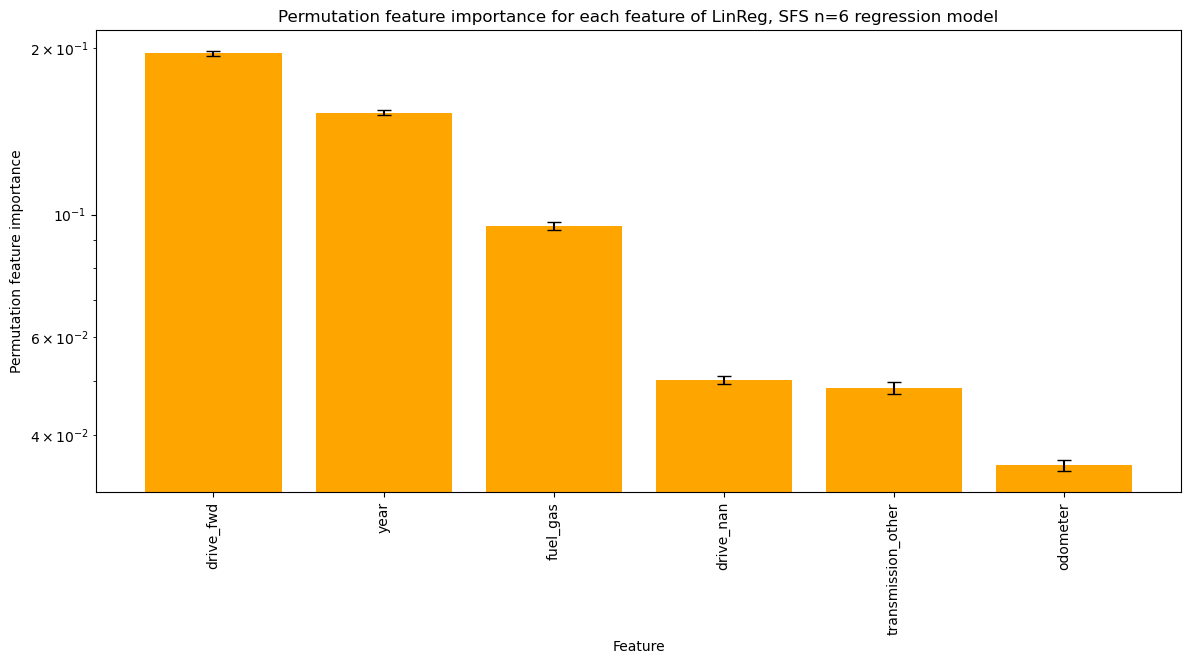

In [84]:
#Create a plot of feature importance
plt.figure(figsize=(14, 6))
plt.bar(Importance5.index, Importance5['Importance'], yerr=Importance5['std_dev'], capsize=5, color='orange')

# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.yscale('log')
plt.ylabel('Permutation feature importance')
plt.title('Permutation feature importance for each feature of LinReg, SFS n=6 regression model')
# Save the plot to a file
plt.savefig('./Images/Fig5.png', format='png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

### Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg), n=3

In [86]:
#Create selector pipeline with Sequential Feature Selection and Linear Regression esitmator for 3 features.
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression(),n_features_to_select=3)),
                          ('linreg', LinearRegression(n_jobs=-1))]).fit(X_train, y_train)

#Predict Test and Train values
train_preds = selector_pipe.predict(X_train)
test_preds = selector_pipe.predict(X_test)

# Calculate Mean Squared Errors for Train and Test
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

#Print R2 score, Mean square errors and best alpha hyperparameter
print(f'Score: {selector_pipe.score(X_test, y_test)}')
print(f'Train MSE: {round(selector_train_mse,3)}')
print(f'Test MSE: {round(selector_test_mse,3)}')

#Get names of parameters
selected_features = selector_pipe.named_steps['selector'].get_feature_names_out()
selected_features_clean = [name.replace('remainder__', '').replace('onehotencoder__', '') for name in selected_features]
#Get coefficientst
best_estimator_coef = selector_pipe.named_steps['linreg'].coef_
#Create dataframe of coefficients
R6 = pd.DataFrame([best_estimator_coef], columns=selected_features_clean, index=['Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg n=3)'])
R6[['Train MSE','Test MSE', 'R2_score']] =selector_train_mse, selector_test_mse, selector_pipe.score(X_test, y_test)

#Perform feature importance permutation 
r = permutation_importance(selector_pipe.named_steps['linreg'], X_test[selected_features], y_test,
                           n_repeats=30,
                           random_state=0,
                           n_jobs=-1)

#Create a dataframe of feature importance
Importance6 = pd.DataFrame(data=[r.importances_mean, r.importances_std, best_estimator_coef],
                          columns=selected_features_clean,
                          index=['Importance','std_dev','Coefficient']).transpose().sort_values(by='Importance',ascending=False)
Importance6.head(20)

Score: 0.24401754102480622
Train MSE: 170737418.227
Test MSE: 168634200.748


C:\Users\grzyb\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Importance,std_dev,Coefficient
year,0.222131,0.002045,-516.126039
drive_fwd,0.128007,0.001449,-8743.099541
fuel_gas,0.116204,0.001890,-9836.149948


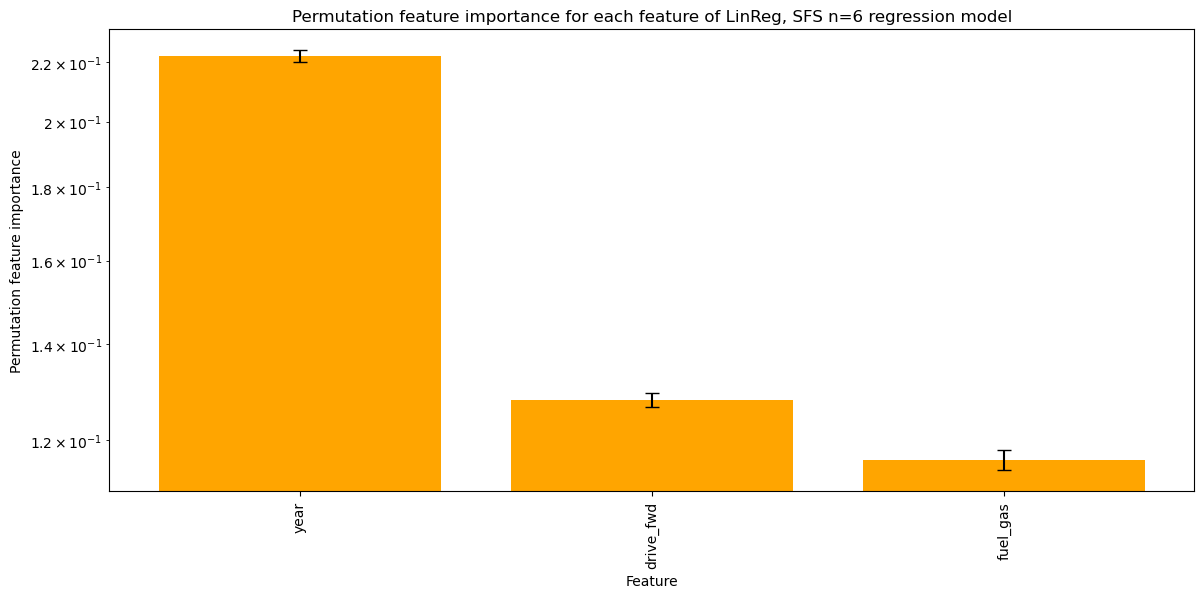

In [87]:
#Create a plot of feature importance
plt.figure(figsize=(14, 6))
plt.bar(Importance6.index, Importance6['Importance'], yerr=Importance6['std_dev'], capsize=5, color='orange')

# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.yscale('log')
plt.ylabel('Permutation feature importance')
plt.title('Permutation feature importance for each feature of LinReg, SFS n=6 regression model')
# Save the plot to a file
plt.savefig('./Images/Fig6.png', format='png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

### Linear Regression, Hold-out cross-validation, polynomial degree=2

In [89]:
#Call Linear regression 
linreg = LinearRegression(n_jobs=-1).fit(X2_train, y_train)

#Predict train and test values
linreg_train_preds = linreg.predict(X2_train)
linreg_test_preds = linreg.predict(X2_test)

#Calculate MSE for train and test set
linreg_train_mse = mean_squared_error(y_train, linreg_train_preds)
linreg_test_mse = mean_squared_error(y_test, linreg_test_preds)

#Print R2 score, train and Test MSE
print(f'Score: {linreg.score(X2_test, y_test)}')
print(f'Train MSE: {round(linreg_train_mse,3)}')
print(f'Test MSE: {round(linreg_test_mse,3)}')

#Perform feature importance permutation
r = permutation_importance(linreg, X2_test, y_test,
                           n_repeats=5,
                           random_state=0,
                           n_jobs=-1)

#Get names of parameters
selected_features = linreg.feature_names_in_
selected_features_clean = [name.replace('remainder__', '').replace('onehotencoder__', '').replace('polynomialfeatures__', '') for name in selected_features]

#Create dataframe of coefficients
best_estimator_coef = linreg.coef_
R7 = pd.DataFrame([best_estimator_coef], columns=selected_features_clean, index=['Linear Regression, Hold-out crossvalidation, polynomial degree=2'])
R7[['Train MSE','Test MSE', 'R2_score']] =linreg_train_mse, linreg_test_mse, linreg.score(X2_test, y_test)

#Create Dataframe of feature importance
Importance = pd.DataFrame(data=[r.importances_mean, r.importances_std, linreg.coef_],
                          columns=selected_features_clean,
                          index=['Importance','std_dev','Coefficient']).transpose().sort_values(by='Importance',ascending=False)
#Print first 20 elements of the Importance dataframe
Importance.head(20)

Score: 0.5911134397751987
Train MSE: 84886037.866
Test MSE: 91208807.111


,Importance,std_dev,Coefficient
title_status_clean odometer,4180.462101,5.392463,-3.646013
odometer,2798.989218,2.641153,2.879748
size_nan odometer,1225.911804,2.427854,-2.369019
fuel_gas odometer,540.078303,0.527228,1.421199
size_full-size odometer,356.552009,0.489382,-2.361687
size_mid-size odometer,283.050736,0.599655,-2.353347
size_compact odometer,271.371807,0.198055,-2.362388
title_status_missing odometer,172.436359,0.020245,-3.645597
title_status_parts only odometer,156.265357,0.034769,-3.647983
fuel_diesel odometer,114.229040,0.368525,1.426647


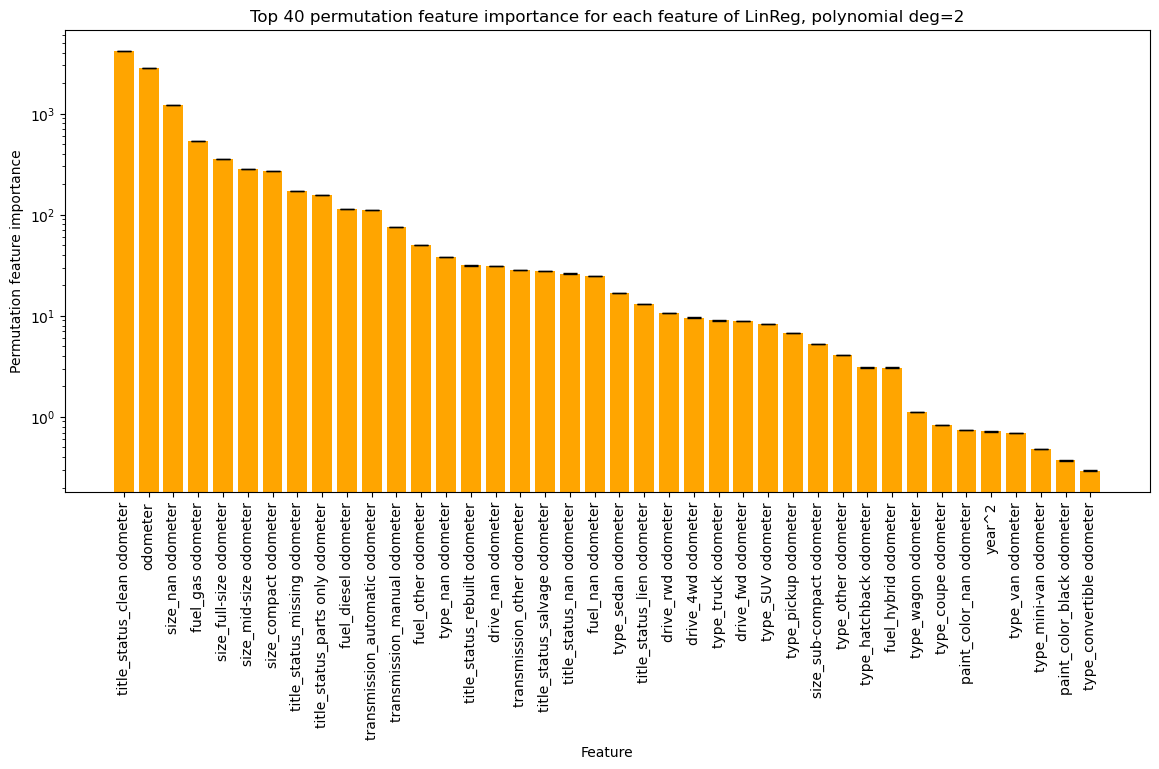

In [90]:
top_importance = Importance.head(40)
## Create a plot of feature importance
plt.figure(figsize=(14, 6))
plt.bar(top_importance.index, top_importance['Importance'], yerr=top_importance['std_dev'], capsize=5, color='orange')

# Adding labels and title
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.yscale('log')
plt.ylabel('Permutation feature importance')
plt.title('Top 40 permutation feature importance for each feature of LinReg, polynomial deg=2')

# Save the plot to a file
plt.savefig('./Images/Fig7.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Evaluation

### Models Evaluation metrics:
    - Mean Square Error
    - R2 Square
### Rationale for evaluation metrics:
Mean Squared Error (MSE) is a widely used metric in linear regression because it penalizes larger errors by squaring the differences between predicted and actual values, making it sensitive to outliers. MSE offers a convex loss function in linear regression, ensuring that optimization converges to a global minimum.

The R2 score, also known as the coefficient of determination, is widely used to evaluate the performance of linear models. It measures the proportion of the variance in the dependent variable that is predictable from the independent variables.  However, R2 can sometimes be misleading, especially in models with many predictors, as it naturally increases with more variables, even if they do not improve the model's predictive power. 

### Summary of models parameters and scores

### I have run three different models on following parameters sets: 
    -'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year', 
    -'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year', 'state'
    -'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year', 'region'
    -'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year', 'manufacturer'
    -'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year', 'model'
    -'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year', 'state', 'manufacturer'
    -'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year', 'state', 'model'

### Tested target transformation:
    - None
    - log1p
    
### Models tested:
    - Linear regression
    - Lasso regression
    - Ridge regression
    - Linear regression, polynomial degree=2
### For linear regression I have then tested:
    - Sequential Feature selection
    - Recursive Feature elimination (it was achieving very bad performance and it is not shown)

### Parameter weights, mean square error of test and train, and R2 score are presented in table below.
### Conclusions:
    1. Out of all combinations of parameters, I used 'size', 'paint_color', 'drive', 'fuel', 'transmission', 'type', 'title_status', 'odometer', 'condition', 'year' to build the models. Adding 'manufacturer', 'model', 'state', or 'region' improved the overall R² score of the model, but the parameter weights were finding some local minima that were not interpretable or were nonsensical. As such, 'manufacturer', 'model', 'state', or 'region' were not used.
    2. Polynomial degree = 2 linear regression showed the best results, with an R² score of 0.59, although that model had an excessive number of parameters likely to inflate the predictive score. Furthermore, the R² score is poorly suited for polynomial models.
    3. For non-polynomial models, linear regression, Lasso, and Ridge regression showed the best results, although the alpha parameter of Lasso and Ridge regressions was optimized to very low alphas. For that reason, I used linear regression in Sequential Feature Selection, as the coefficients are more interpretable for linear regression compared to Lasso and Ridge models.
    4. Non-polynomial linear regression gave an R² score of 0.4 when using 59 parameters.
    5. Subsetting with Sequential Feature Selection to 16 parameters out of 59 yielded an R² score of 0.37.
    6. Subsetting with Sequential Feature Selection to 6 parameters out of 59 yielded an R² score of 0.3.
    7. Subsetting with Sequential Feature Selection to 3 parameters out of 59 yielded an R² score of 0.25.
    8. Using RFE instead of Sequential Feature Selection resulted in a significant loss of predictive power, with an R² score below 0.1 (tested but not shown).
    9. The log1p transformation of the target column 'price' decreased the performance of the model; therefore, for ease of interpretation and better quality, I left that column untransformed.

In [93]:
#Dispaly a summary of all non-polynomial models for set of parameters 'size','paint_color','drive', 'fuel','transmission','type','title_status', 'odometer', 'condition', 'year',
pd.set_option('display.max_columns', None)
concatenated_df = pd.concat([R1,R2,R3,R4,R5,R6], axis=0)
#Sort models by R2 score
concatenated_df.sort_values('R2_score',ascending=False)

,size_compact,size_full-size,size_mid-size,size_sub-compact,size_nan,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,paint_color_nan,drive_4wd,drive_fwd,drive_rwd,drive_nan,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,fuel_nan,transmission_automatic,transmission_manual,transmission_other,transmission_nan,type_SUV,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,type_nan,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,title_status_nan,year,condition,cylinders,odometer,cylinders_other,condition_nan,Train MSE,Test MSE,R2_score
"Lasso Regression, 10-fold cross-validation, non-polynomial",-229.913362,-1150.034652,-420.030287,-249.496554,146.973505,631.384636,39.940540,-25.989674,133.657930,-69.886997,107.286411,82.872281,78.352494,121.931875,-184.086592,541.683160,195.074485,-364.909414,1677.185678,-1064.877808,860.508506,-5.687645,2864.674131,243.572333,-638.135426,-33.206235,419.967487,-40.990019,-2538.161972,-757.453149,513.657955,-393.167488,-262.878083,-285.962073,742.995226,956.561550,-604.899612,-209.856430,120.817505,953.853522,1140.347510,-599.693607,1103.088092,189.997347,-468.391728,-609.855033,675.304274,351.735145,285.715714,-52.695204,3.594300,-204.723089,-135.022279,-4131.735314,4266.599528,5724.199372,-1858.089574,5643.403991,5341.568396,1.347941e+08,1.345300e+08,0.396906
"Ridge Regression, 10-fold cross-validation, non-polynomial",8.682466,-736.267253,-102.397078,-151.143875,669.635368,499.371814,-57.418981,-72.406068,86.373389,-119.265230,20.754513,57.477769,62.941319,25.243739,-296.209438,397.733881,168.389589,-534.163581,1293.773031,-1424.430033,571.710027,-388.933867,2341.861953,109.038195,-1407.124372,-264.770961,-121.727422,-194.181484,-1319.659875,-56.190305,1580.416203,-209.557742,-429.109779,-301.324458,684.035180,865.651134,-690.477283,-256.139370,103.825878,858.785319,1007.622986,-774.072734,986.731520,129.108193,-536.397966,-788.344622,355.799009,266.137599,221.496299,-83.828746,-187.016571,-346.541233,-328.028906,-4131.714371,4266.722552,5724.025557,-1858.098987,5643.247149,5341.698813,1.347941e+08,1.345301e+08,0.396905
"Linear Regression, Hold-out crossvalidation, non-polynomial",581.420597,-1528.009538,164.668911,-1245.405414,2027.325444,1084.425401,-536.402345,-896.526297,358.955012,-1213.761627,-228.920342,520.333901,1193.267687,-221.074167,-1297.472842,706.360015,2018.761909,-1487.946305,2729.010437,-3374.701390,1568.553453,-922.862500,9065.718648,1405.076905,-4107.123305,-2674.135394,-755.787453,-2933.749400,-2575.153978,368.624477,4952.378183,-2745.848681,-1174.791438,-8567.192253,4963.892669,4064.770819,-3551.520541,-2454.632428,2583.949140,3853.560474,3229.815745,-1979.236042,3614.070651,860.741291,-3473.744178,-1969.683910,1629.000614,4491.332820,4978.539998,-3836.830898,-1376.927490,-3476.476904,-2408.638141,-432.108019,2359.637217,1803.126085,-0.011182,11471.554907,10988.359709,1.347941e+08,1.345301e+08,0.396905
"Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg n=16)",NaN,NaN,NaN,NaN,2500.553385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7719.116068,NaN,-4160.974767,10145.348519,NaN,-3191.728377,NaN,NaN,NaN,NaN,NaN,8147.182535,NaN,NaN,NaN,7421.187002,6748.370390,NaN,NaN,NaN,6381.201507,6411.436558,NaN,6985.395512,NaN,NaN,NaN,3967.707953,NaN,NaN,NaN,NaN,NaN,NaN,-400.873575,2165.210819,NaN,-0.011195,NaN,10420.409050,1.404308e+08,1.398062e+08,0.373253
"Linear Regression, Hold-out cross-validation, non-polynomial, SFS(LinReg n=6)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10799.397848,NaN,-5177.698724,NaN,NaN,-8867.933517,NaN,NaN,NaN,NaN,NaN,6341.290380,NaN,NaN,NaN,NaN,NaN,NaN

## Deployment

### Business Objectives
The objective of this exercise is to create predictive model of of used car prices that can be used to readily asses fair value for used cars. 

### Model rationale:
To explain the observations, I have chosen a non-polynomial linear regression model based on 'size', 'paint_color', 'drive', 'fuel', 'transmission', 'type', 'title_status', 'odometer', 'condition', and 'year'. This model explains approximately 40% of the variability in car prices, and while the coefficients are imperfect, they can be used to approximate the value in USD for each change in a parameter. The observations are listed in a table called Importance1, sorted in decreasing importance to the model. I will also comment on the most important features that can be used to build a model with almost as good predictive power, based on observations from Sequential Feature Selection experiments.
### Observations:
    1. Condition of the car is high a importance parameter with labels scores: 'new':6, 'like new':5, 'excellent':4, 'good':3, 'fair':2, 'salvage':1. It can be approximated that for each step up in car condition on average car can sell for extra +2400/level. When car condition is unknown on average it can be assumed to be equivalent to good/excellent condition.
    2. Number of cylinders tracks well with a car price with every extra cylinder corresponding to +1800/cylinder.
    3. Age of car is another important parameter on avearge each extra year corresponds to 430/year discount.
    4. Odometer reading can be used to predict a price with every 10,000 miles on odometer translating into -100 discount (-0.01/mile).
    5. Among car types convertibles(+5000), coupes(+4100), trucks(+3600), pickups(+3200) and offroads(+2600) sell for higher price than other categories like bus(-8600), hatchback(-3600), wagon(-3500).  
    6. Fuel category is interesting although replacable by size or type category, diesel cars tend to be overrepresented in a cateogry trucks which tend to have higer price, as such average price difference between gas(-4100) and diesel(+9100) cars is ~13200.
    7. Among type of drives, 4wd(+2700) is the most expensive followed by RWD(+1600) and FWD(-3400).
    8. Transmission label "other"(+5000) tracks with higher value likely due to correlation with being used in utility vehicles. 
    9. Title status influences the price lien(+4500), clean(+1600), rebuilt(-1400), parts_only(-3800), salvage(-3500). Interestingly missing(+5000) and NA(-2400) are distinguishable although they do not build good models. It is unclear why missing title sells at premium. 
    10. Size is not very good parameter as it refers only to passanger cars pushing all other cars into NaN category: compact(+600), mid-size(+200), full-size(-1500), compact(-1200), NaN(+2000).
    11. While paint color is not particularly important feature, among colors yellow(+2000), purple(+1200) and black(+1100) sells for the highest price and silver(-1300), green(-1200) and brown(-900) sell for the lowest. 

### Future Directions:
    1. Build a model taking into consideration the 'manufacturer', 'model', 'state', or 'region' parameters that were excluded from this analysis.
    2. Split the dataset between trucks and passenger cars, as it would create two more interpretable models that are currently intertwined in the existing model.


In [95]:
#Summary of the data for non-polynomial linear regression model using all parameters. 
Importance1

,Importance,std_dev,Coefficient
cylinders,0.298092,0.002289,1803.126085
cylinders_other,0.280153,0.002964,11471.554907
condition_nan,0.247397,0.002056,10988.359709
condition,0.168288,0.001740,2359.637217
year,0.154338,0.001450,-432.108019
fuel_diesel,0.046701,0.000799,9065.718648
odometer,0.031404,0.000766,-0.011182
transmission_other,0.029512,0.000795,4952.378183
fuel_gas,0.020746,0.000669,-4107.123305
drive_fwd,0.019469,0.000623,-3374.701390


![](images/Fig1.png)
![](images/Fig1b.png)